In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import hvplot.pandas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import pmdarima as pm

In [2]:
# Read the CSV file
df = pd.read_csv('D:/Desktop/FPT Historical Data Monthly.csv')

In [3]:
# transform column 'Date' to  datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [4]:
# some format data
df.set_index('Date',drop=True,inplace=True)
df.head()

df

,Price
Date,
2007-01-01,26139.5
2007-02-01,25612.7
2007-03-01,21945.5
2007-04-01,17240.0
2007-05-01,21235.6
...,...
2023-07-01,85600.0
2023-08-01,96700.0
2023-09-01,92800.0


In [5]:
df

,Price
Date,
2007-01-01,26139.5
2007-02-01,25612.7
2007-03-01,21945.5
2007-04-01,17240.0
2007-05-01,21235.6
...,...
2023-07-01,85600.0
2023-08-01,96700.0
2023-09-01,92800.0


<Axes: xlabel='Date'>

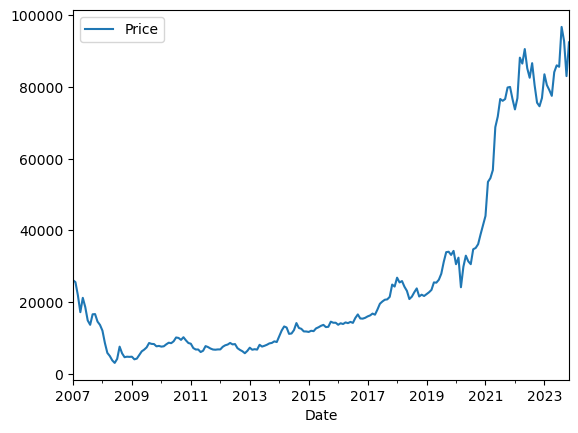

In [6]:
df.plot()

# split data to train and test

In [7]:
train_size = int(len(df) * 0.9)

# Split the DataFrame into training and testing sets
train = df[:train_size]
test = df[train_size:]

In [8]:
test

,Price
Date,
2022-03-01,88141.7
2022-04-01,86494.2
2022-05-01,90530.6
2022-06-01,85209.2
2022-07-01,82540.3
2022-08-01,86600.0
2022-09-01,80500.0
2022-10-01,75600.0
2022-11-01,74600.0


In [9]:
print('\n----------train----------\n')
train.info()
print('\n----------test----------\n')
test.info()


----------train----------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2007-01-01 to 2022-02-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   182 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB

----------test----------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 2022-03-01 to 2023-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   21 non-null     float64
dtypes: float64(1)
memory usage: 336.0 bytes


In [10]:
# adfuller for data train 

adf_0 = adfuller(df)
print('ADF stationary is:', adf_0[0])
print('p-value of ADF test is:', adf_0[1])
print('Critical values:')
for key, value in adf_0[4].items():
    print('\t%s: .%.3f'%(key,value))

ADF stationary is: 0.1614096592298381
p-value of ADF test is: 0.970012201805755
Critical values:
	1%: .-3.466
	5%: .-2.877
	10%: .-2.575


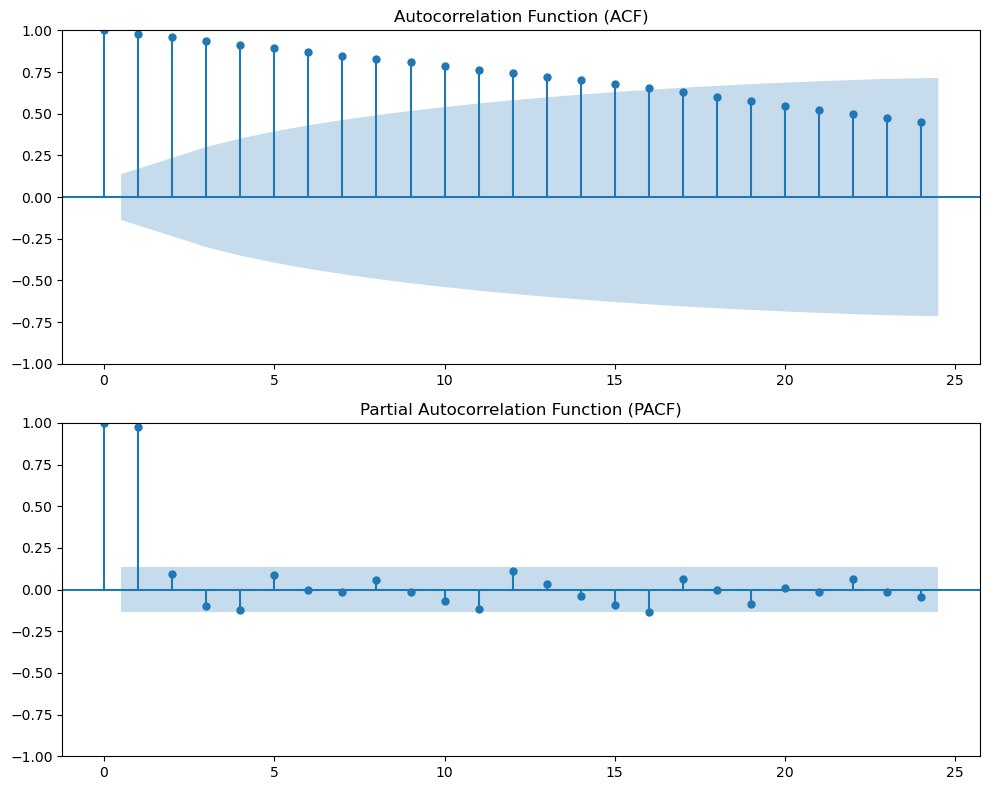

In [11]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(10, 8))

# ACF plot
plot_acf(df, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [12]:
# Function to perform differencing
def difference(data, d=1):
    """
    Perform differencing on a time series data for 'd' orders.
    data: Pandas Series or DataFrame
    d: Order of differencing (default = 1 for first difference)
    """
    if isinstance(data, pd.Series):
        # If data is a Pandas Series
        diff_series = data.diff(periods=d).dropna()
        return pd.DataFrame({f'Difference_{d}': diff_series})
    elif isinstance(data, pd.DataFrame):
        # If data is a Pandas DataFrame, operate on the specified column
        diff_series = data.iloc[:, 0].diff(periods=d).dropna()
        return pd.DataFrame({f'Difference_{d}': diff_series})
    else:
        raise ValueError("Input should be a Pandas Series or DataFrame")

In [13]:
# First Difference stored in a new DataFrame
first_difference = difference(df, d=1)

In [14]:
first_difference

,Difference_1
Date,
2007-02-01,-526.8
2007-03-01,-3667.2
2007-04-01,-4705.5
2007-05-01,3995.6
2007-06-01,-2555.6
...,...
2023-07-01,-400.0
2023-08-01,11100.0
2023-09-01,-3900.0


# Step 4: plot AFC and PACF

adf_1 = adfuller(first_difference)
print('ADF 1diff stationary is:', adf_1[0])
print('p-value of ADF 1diff test is:', adf_1[1])
print('Critical values 1diff:')
for key, value in adf_1[4].items():
    print('\t%s: .%.3f'%(key,value))

# => The model stops at i differencing

ADF 2diff stationary is: -4.884652990701464
p-value of ADF 2diff test is: 3.735425322428123e-05
Critical values 2diff:
	1%: .-3.466
	5%: .-2.877
	10%: .-2.575


<Axes: xlabel='Date'>

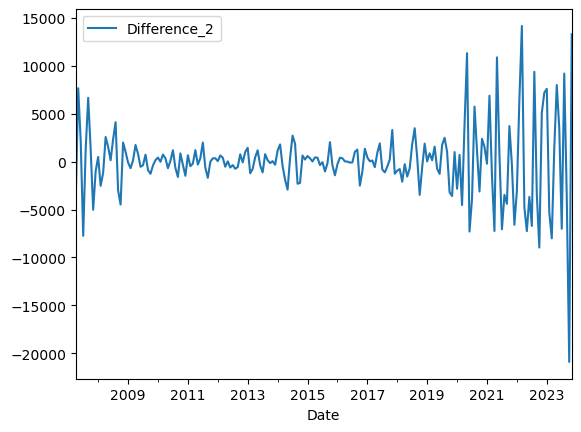

In [15]:
# First Difference stored in a new DataFrame
train_2_difference = difference(first_difference, d=2)

adf_2 = adfuller(train_2_difference)
print('ADF 2diff stationary is:', adf_2[0])
print('p-value of ADF 2diff test is:', adf_2[1])
print('Critical values 2diff:')
for key, value in adf_2[4].items():
    print('\t%s: .%.3f'%(key,value))

train_2_difference.plot()

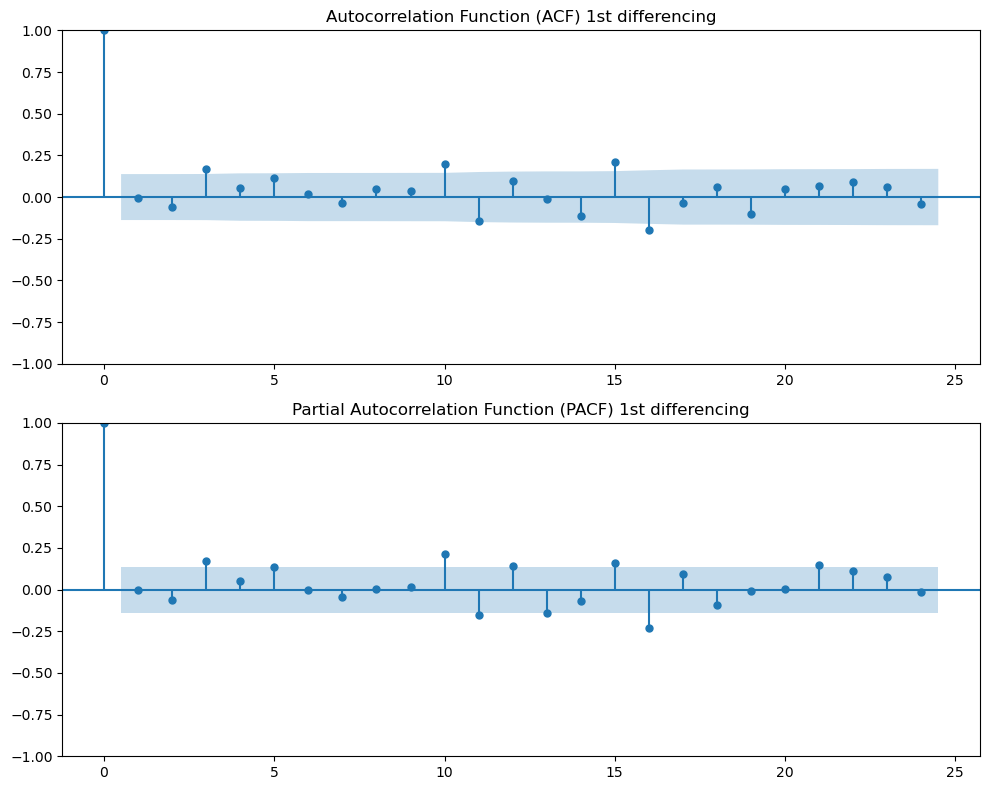

In [16]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(10, 8))

# ACF plot
plot_acf(first_difference, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) 1st differencing')

# PACF plot
plot_pacf(first_difference, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) 1st differencing')

plt.tight_layout()
plt.show()

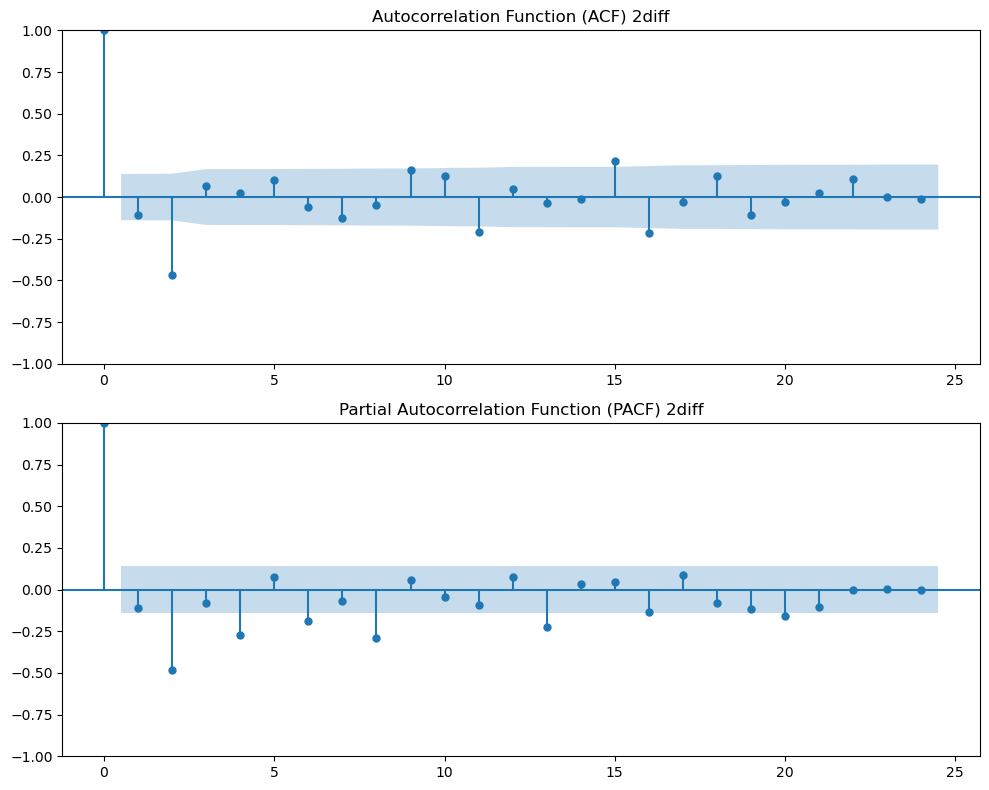

In [17]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(10, 8))

# ACF plot
plot_acf(train_2_difference, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) 2diff')

# PACF plot
plot_pacf(train_2_difference, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) 2diff')

plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

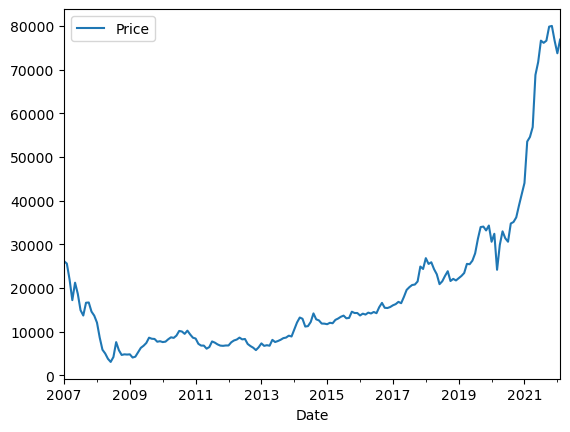

In [18]:
train.plot()

# Step 5: fit model, forecast and plot forecast

# auto arima

In [19]:
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [20]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -1628.080
Date:                Fri, 17 Nov 2023   AIC                           3270.161
Time:                        14:02:49   BIC                           3292.511
Sample:                    01-01-2007   HQIC                          3279.223
                         - 02-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.2383      6.789      2.392      0.017       2.932      29.545
ar.L1         -0.0833      0.095     -0.880      0.379      -0.269       0.102
ar.L2         -0.7136      0.084     -8.465      0.000      -0.879      -0.548
ma.L1         -0.7019      0.110     -6.395      0.000      -0.917      -0.487
ma.L2          0.3704      0.126      2.947      0.003       0.124       0.617
ma.L3         -0.6421      0.083     -7.757      0.000      -0.804      -0.480
sigma2      3.543e+06   1.56e+05     22.657      0.000    3.24e+06    3.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               918.16
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))

<Axes: xlabel='Date'>

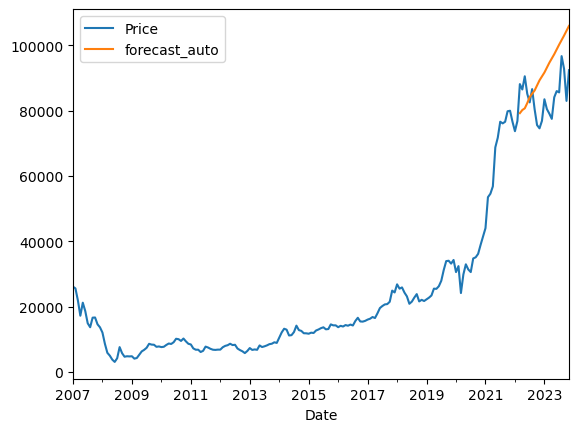

In [22]:
# add to new column of df to plot
df['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

df.plot()

In [23]:
mea_auto = mean_absolute_error(test, forecast_test_auto)
rmse_auto = np.sqrt(mean_squared_error(test, forecast_test_auto))

print(f'mae - manual: {mea_auto}')
print(f'rmse - manual: {rmse_auto}')

mae - manual: 10597.340231348076
rmse - manual: 11835.679195987841


# Manual model

In [24]:
# Read the CSV file
df__ = pd.read_csv('D:/Desktop/FPT Historical Data Monthly.csv')

In [25]:
df__.tail(10)

,Date,Price
193,2/1/2023,80500.0
194,3/1/2023,79100.0
195,4/1/2023,77500.0
196,5/1/2023,84100.0
197,6/1/2023,86000.0
198,7/1/2023,85600.0
199,8/1/2023,96700.0
200,9/1/2023,92800.0
201,10/1/2023,83000.0
202,11/1/2023,92400.0


In [26]:
# Transform 'Date' to format datetime
df__['Date'] = pd.to_datetime(df__['Date'], errors='coerce')

In [27]:
df__

,Date,Price
0,2007-01-01,26139.5
1,2007-02-01,25612.7
2,2007-03-01,21945.5
3,2007-04-01,17240.0
4,2007-05-01,21235.6
...,...,...
198,2023-07-01,85600.0
199,2023-08-01,96700.0
200,2023-09-01,92800.0
201,2023-10-01,83000.0


In [28]:
for _ in range(3):
    last_date = df__['Date'].dropna().iloc[-1]
    next_date = last_date + relativedelta(months=1)
    new_row = pd.DataFrame({'Date': [next_date], 'Price': [None]})
    df__ = pd.concat([df__, new_row], ignore_index=True)


In [29]:
df__.tail(10)

,Date,Price
196,2023-05-01,84100.0
197,2023-06-01,86000.0
198,2023-07-01,85600.0
199,2023-08-01,96700.0
200,2023-09-01,92800.0
201,2023-10-01,83000.0
202,2023-11-01,92400.0
203,2023-12-01,NaN
204,2024-01-01,NaN
205,2024-02-01,NaN


In [30]:
# some format data
df__.set_index('Date',drop=True,inplace=True)

df__

,Price
Date,
2007-01-01,26139.5
2007-02-01,25612.7
2007-03-01,21945.5
2007-04-01,17240.0
2007-05-01,21235.6
...,...
2023-10-01,83000.0
2023-11-01,92400.0
2023-12-01,NaN


In [31]:
# Define the p, d, q values
p_values = [3, 10, 15, 16]
d_value = 1
q_values = [3, 10, 15, 16]

In [32]:
# Create an empty list to store the results
results = []

In [33]:
# Loop over the p and q values
for p in p_values:
    for q in q_values:
        # Try to fit the ARIMA model
        try:
            model = ARIMA(train, order=(p, d_value, q))
            model_fit = model.fit()
            
            # Forecast on the test set
            forecast = model_fit.forecast(steps=len(test))
            
            # Calculate MAE and RMSE
            mae = mean_absolute_error(test, forecast)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            
            # Append the model summary and the criteria to the results list
            results.append((p, q, model_fit.summary(), model_fit.llf, model_fit.aic, model_fit.bic, model_fit.hqic, mae, rmse))
        # Handle the exception if the model fails to converge
        except Exception as e:
            print(f'Failed to fit ARIMA({p}, {d_value}, {q}) model due to {e}')

# Sort the results by the log likelihood in descending order
results.sort(key=lambda x: x[3], reverse=True)

E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages

E:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary st

In [34]:
# Print the results
for p, q, summary, llf, aic, bic, hqic, mae, rmse in results:
    print(f'ARIMA({p}, {d_value}, {q}) model')
    print(f'Log likelihood: {llf}')
    print(f'AIC: {aic}')
    print(f'BIC: {bic}')
    print(f'HQIC: {hqic}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

    print('-'*80)

ARIMA(15, 1, 15) model
Log likelihood: -1593.9057038077258
AIC: 3249.8114076154516
BIC: 3348.964815584692
HQIC: 3290.0103197998073
MAE: 15287.624241005768
RMSE: 15927.946581302971
--------------------------------------------------------------------------------
ARIMA(16, 1, 16) model
Log likelihood: -1595.0591547476301
AIC: 3256.1183094952603
BIC: 3361.6687115270324
HQIC: 3298.910699885058
MAE: 15069.040109002719
RMSE: 15833.340700864183
--------------------------------------------------------------------------------
ARIMA(16, 1, 15) model
Log likelihood: -1595.2694311787823
AIC: 3254.5388623575645
BIC: 3356.890767358071
HQIC: 3296.0345136446413
MAE: 14183.956090999069
RMSE: 14994.99491296692
--------------------------------------------------------------------------------
ARIMA(15, 1, 16) model
Log likelihood: -1595.6382986168453
AIC: 3255.2765972336906
BIC: 3357.628502234197
HQIC: 3296.7722485207673
MAE: 15583.415171693434
RMSE: 16368.304011641783
--------------------------------------

# (3, 1, 3) is a suitable model

In [35]:
# Fit an ARIMA model
model_313 = ARIMA(train, order=(3, 1, 3))
model_fit_313 = model_313.fit()

# Summary of the model
print(model_fit_313.summary())

E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
E:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  182
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1619.525
Date:                Fri, 17 Nov 2023   AIC                           3253.049
Time:                        14:03:11   BIC                           3275.439
Sample:                    01-01-2007   HQIC                          3262.126
                         - 02-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0269      0.164      6.259      0.000       0.705       1.348
ar.L2         -1.0448      0.122     -8.593      0.000      -1.283      -0.806
ar.L3          0.4739      0.146      3.246      0.0

In [36]:
# predict for6 month in future
forecast__313 = model_fit_313.forecast(len(test)+3)
print("\nForecast:")
print(forecast__313)


Forecast:
2022-03-01    76743.630573
2022-04-01    74873.368964
2022-05-01    74041.129553
2022-06-01    75087.070675
2022-07-01    76144.246725
2022-08-01    75742.677361
2022-09-01    74721.525206
2022-10-01    74593.481478
2022-11-01    75338.529426
2022-12-01    75753.431133
2023-01-01    75340.415497
2023-02-01    74835.924879
2023-03-01    74946.001609
2023-04-01    75390.365413
2023-05-01    75492.582165
2023-06-01    75185.466236
2023-07-01    74973.898041
2023-08-01    75125.944280
2023-09-01    75357.563935
2023-10-01    75336.292784
2023-11-01    75144.523818
2023-12-01    75079.592705
2024-01-01    75203.185551
2024-02-01    75307.053693
Freq: MS, Name: predicted_mean, dtype: float64


In [37]:
len__ = len(test)
first_part = forecast__313[:len__]
second_part = forecast__313[len__:]

second_part

2023-12-01    75079.592705
2024-01-01    75203.185551
2024-02-01    75307.053693
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
first_part.shape

(21,)

<Axes: xlabel='Date'>

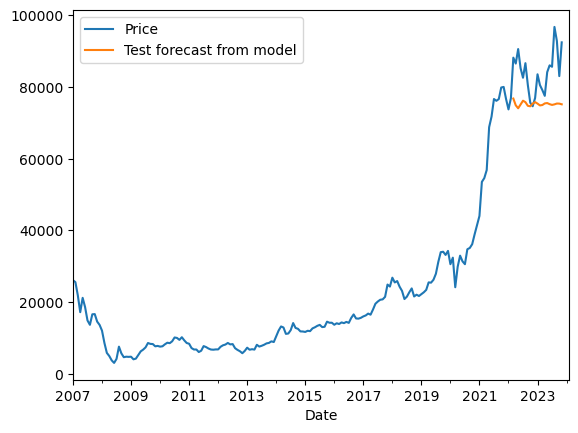

In [39]:
df__['Test forecast from model'] = [None]*len(train) + list(first_part) + [None]*len(second_part)

df__.plot()

<Axes: xlabel='Date'>

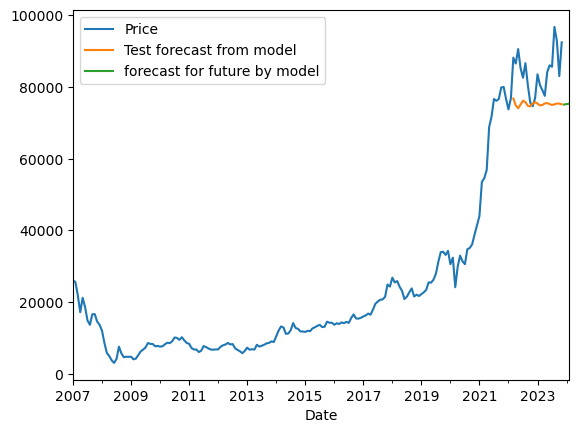

In [40]:
df__['forecast for future by model'] = [None]*len(train) + [None]*len(first_part) + list(second_part)

df__.plot()